In [ ]:
! pip install transformers tensorflow pandas scikit-learn emoji contractions matplotlib nltk seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re, emoji, contractions
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
df = pd.read_csv("/content/labeled_data.csv")
df = df[['tweet', 'class']]
df = df.rename(columns={'tweet':'text','class':'label'})

In [ ]:
#preprocessing

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = contractions.fix(text)
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

df['text'] = df['text'].apply(clean_text)

In [ ]:
df.size

49566

In [ ]:
le=LabelEncoder()
df['label']=le.fit_transform(df['label'])

In [ ]:
# 80% Train + 20% Temp (Validation + Test)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Split 20% Temp into 50% Validation and 50% Test
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

In [ ]:
#Tokenization (BERT)

MODEL_NAME = "bert-base-uncased"

avg_len = int(df['text'].str.split().apply(len).mean())
MAX_LEN = min(200, avg_len * 2)

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=MAX_LEN, return_tensors='tf')
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=MAX_LEN, return_tensors='tf')
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=MAX_LEN, return_tensors='tf')

train_labels = tf.convert_to_tensor(train_labels)
val_labels = tf.convert_to_tensor(val_labels)
test_labels = tf.convert_to_tensor(test_labels)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [ ]:
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(le.classes_), from_pt=True)

# Full fine-tuning: all layers trainable
for layer in model.layers:
    layer.trainable = True

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Compile Model

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
#class weights for handle imbalance

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df['label']), y=df['label'])
class_weights = dict(enumerate(class_weights))

In [ ]:
#Callbacks

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model', monitor='val_loss', save_best_only=True, save_format='tf')
]

In [ ]:
# Convert encodings + labels to tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask']
    },
    train_labels)).shuffle(1000).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': val_encodings['input_ids'],
        'attention_mask': val_encodings['attention_mask']
    },
    val_labels)).batch(16)

In [ ]:
# Train model

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/10
1240/1240 [==============================] - 267s 164ms/step - loss: 0.6500 - accuracy: 0.7363 - val_loss: 0.4675 - val_accuracy: 0.8119
Epoch 2/10
1240/1240 [==============================] - 129s 104ms/step - loss: 0.4708 - accuracy: 0.7780 - val_loss: 0.4831 - val_accuracy: 0.8269
Epoch 3/10
1240/1240 [==============================] - 200s 162ms/step - loss: 0.3616 - accuracy: 0.8191 - val_loss: 0.4514 - val_accuracy: 0.8349
Epoch 4/10
1240/1240 [==============================] - 230s 185ms/step - loss: 0.2492 - accuracy: 0.8674 - val_loss: 0.4248 - val_accuracy: 0.8519
Epoch 5/10
1240/1240 [==============================] - 119s 96ms/step - loss: 0.1780 - accuracy: 0.9040 - val_loss: 0.5218 - val_accuracy: 0.8382
Epoch 6/10
1240/1240 [==============================] - 118s 95ms/step - loss: 0.1348 - accuracy: 0.9309 - val_loss: 0.5065 - val_accuracy: 0.8584
Epoch 7/10
1240/1240 [==============================] - 118s 95ms/step - loss: 0.1000 - accuracy: 0.9492 - val_los

In [ ]:
# Evaluate on Validation
val_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
    val_labels
)).batch(16)

val_pred = np.argmax(model.predict(val_dataset).logits, axis=1)

# Evaluate on Test
test_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']},
    test_labels
)).batch(16)

test_pred = np.argmax(model.predict(test_dataset).logits, axis=1)

# Reports
from sklearn.metrics import classification_report

print("\nValidation Report:")
val_report = classification_report(val_labels, val_pred, target_names=class_names, output_dict=True)
print(classification_report(val_labels, val_pred, target_names=class_names))

print("\nTest Report:")
test_report = classification_report(test_labels, test_pred, target_names=class_names, output_dict=True)
print(classification_report(test_labels, test_pred, target_names=class_names))

# Average F1
avg_f1 = (val_report['weighted avg']['f1-score'] + test_report['weighted avg']['f1-score']) / 2
print(f"\nAverage F1 (Val+Test): {avg_f1:.4f}")


155/155 [==============================] - 5s 32ms/step

Validation Report:
              precision    recall  f1-score   support

        Hate       0.32      0.62      0.42       143
   Offensive       0.95      0.87      0.91      1919
      Normal       0.80      0.85      0.83       416

    accuracy                           0.85      2478
   macro avg       0.69      0.78      0.72      2478
weighted avg       0.89      0.85      0.87      2478


Test Report:
              precision    recall  f1-score   support

        Hate       0.28      0.52      0.36       143
   Offensive       0.94      0.87      0.90      1919
      Normal       0.79      0.84      0.81       417

    accuracy                           0.84      2479
   macro avg       0.67      0.74      0.69      2479
weighted avg       0.88      0.84      0.86      2479


Average F1 (Val+Test): 0.8614


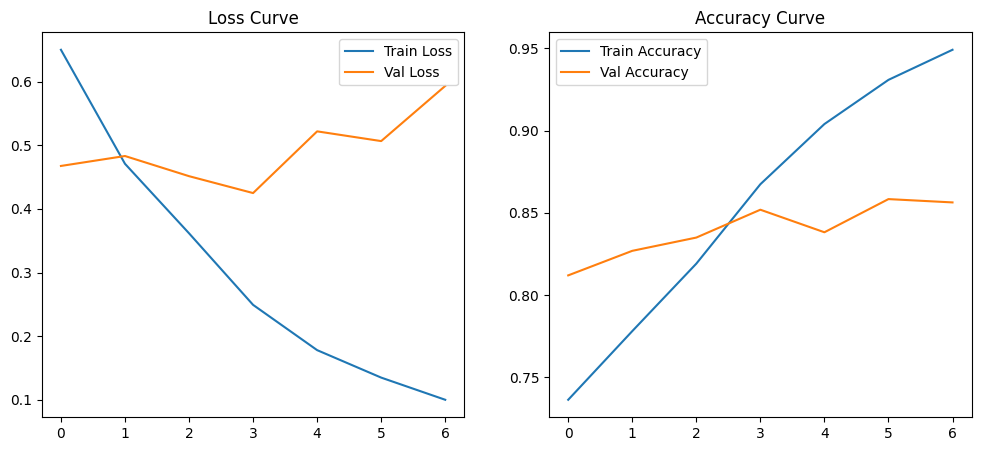

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

In [ ]:
# Prediction on New Text


def predict_text(text):
    text_clean = clean_text(text)
    enc = tokenizer([text_clean], truncation=True, padding=True, max_length=MAX_LEN, return_tensors='tf')
    logits = model(enc).logits
    pred_index = np.argmax(logits.numpy(), axis=1)[0]
    pred_label = class_names[pred_index]
    return pred_label

examples = [
    "I hate those people!",
    "You are amazing!",
    "I don't like this at all.",
    "What a beautiful day!",
    "You are so stupid!",
]

for text in examples:
    print(f"Text: {text}")
    print("Prediction:", predict_text(text))
    print("-" * 50)


Text: I hate those people!
Prediction: Hate
--------------------------------------------------
Text: You are amazing!
Prediction: Normal
--------------------------------------------------
Text: I don't like this at all.
Prediction: Offensive
--------------------------------------------------
Text: What a beautiful day!
Prediction: Normal
--------------------------------------------------
Text: You are so stupid!
Prediction: Hate
--------------------------------------------------
